# Tutorial 05: VECM and Cointegration

**Level:** Advanced  
**Estimated Duration:** 120--150 minutes  
**Prerequisites:** Tutorials 01--04 (Panel VAR estimation, IRF, FEVD, Granger causality)

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Explain** why standard VAR models fail with non-stationary data and why differencing loses information
2. **Define** cointegration and identify cointegrating relationships from economic theory
3. **Write** the VECM specification and interpret the $\Pi = \alpha \beta'$ decomposition
4. **Select** the cointegration rank using trace and max-eigenvalue tests
5. **Estimate** a Panel VECM and interpret the cointegrating vector $\beta$ and loading matrix $\alpha$
6. **Test** economic restrictions on $\beta$ (e.g., Purchasing Power Parity)
7. **Compute** VECM-based IRFs that respect long-run equilibrium constraints
8. **Apply** the VECM framework to multiple economic applications

## Outline

| Section | Topic | Duration |
|---------|-------|----------|
| 1 | Non-Stationarity Problem | 20 min |
| 2 | Cointegration Concept | 25 min |
| 3 | VECM Specification | 20 min |
| 4 | Cointegration Rank Testing | 30 min |
| 5 | VECM Estimation | 25 min |
| 6 | Testing $\beta$ Restrictions | 15 min |
| 7 | IRFs with Long-Run Constraints | 20 min |
| 8 | Economic Applications | 15 min |
| - | Exercises | - |

---

## Setup

In [1]:
# ============================================================
# Setup
# ============================================================
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Reproducibility
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add project root and utilities to path
project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
sys.path.insert(0, '../utils')

# PanelBox imports
from panelbox.var import PanelVARData, PanelVAR, PanelVECM, CointegrationRankTest

# Tutorial utilities
from data_generators import generate_ppp_panel, generate_interest_parity_panel
from visualization_helpers import set_academic_style

# Apply academic style
set_academic_style()

# Output directory
os.makedirs('../outputs/figures/vecm', exist_ok=True)
os.makedirs('../outputs/tables', exist_ok=True)

print('Setup complete.')
print(f'NumPy: {np.__version__}')
print(f'Pandas: {pd.__version__}')

Setup complete.
NumPy: 2.3.5
Pandas: 2.3.3


---

## Section 1: The Non-Stationarity Problem (20 min)

### 1.1 Purchasing Power Parity (PPP)

**Purchasing Power Parity** is one of the most important equilibrium relationships in international economics. It states that the exchange rate between two countries should equal the ratio of their price levels:

$$e_t = p_t^d - p_t^f + c$$

where (in logs):
- $e_t$ = nominal exchange rate
- $p_t^d$ = domestic price level
- $p_t^f$ = foreign price level
- $c$ = constant

Each of these series is **non-stationary** (I(1)) -- they have stochastic trends. But the **deviation** from PPP should be stationary:

$$z_t = e_t - (p_t^d - p_t^f) - c \sim I(0)$$

This is exactly the concept of **cointegration**.

### 1.2 The Dilemma

When working with I(1) variables, we face a dilemma:

| Approach | Problem |
|----------|----------|
| VAR in **levels** | Spurious regression; invalid t-statistics and F-tests |
| VAR in **differences** | Loses long-run equilibrium information (PPP relationship) |
| **VECM** | Correctly separates short-run dynamics from long-run equilibrium |

The VECM elegantly resolves this dilemma by modeling both:
- **Short-run dynamics**: how variables adjust period-to-period
- **Long-run equilibrium**: the cointegrating relationship that binds variables together

### 1.3 Load the PPP Panel Data

We generate a panel of 20 countries observed over 60 quarters, with three variables:
- `exchange_rate` (log nominal exchange rate)
- `price_domestic` (log domestic price index)
- `price_foreign` (log foreign price index)

The data is generated with a built-in cointegrating relationship (PPP holds in the long run).

In [2]:
# Generate PPP panel data
df_ppp = generate_ppp_panel()

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df_ppp['quarter'] = pd.PeriodIndex(df_ppp['quarter'], freq='Q')

print(f'Dataset shape: {df_ppp.shape}')
print(f'Countries: {df_ppp["country"].nunique()}')
print(f'Quarters: {df_ppp["quarter"].nunique()}')
print(f'\nColumns: {list(df_ppp.columns)}')
print(f'\nSample data:')
df_ppp.head(10)

Dataset shape: (1200, 5)
Countries: 20
Quarters: 60

Columns: ['country', 'quarter', 'exchange_rate', 'price_domestic', 'price_foreign']

Sample data:


,country,quarter,exchange_rate,price_domestic,price_foreign
0,USA,2005Q1,1.320718,4.574507,4.286174
1,USA,2005Q2,1.311716,4.574824,4.301361
2,USA,2005Q3,1.308833,4.575141,4.324705
3,USA,2005Q4,1.325789,4.611726,4.326625
4,USA,2006Q1,1.319930,4.632074,4.344678
5,USA,2006Q2,1.308068,4.627685,4.353102
6,USA,2006Q3,1.325231,4.643536,4.346426
7,USA,2006Q4,1.298314,4.639268,4.354847
8,USA,2007Q1,1.274162,4.634953,4.380917
9,USA,2007Q2,1.274593,4.644792,4.383380


In [3]:
# Descriptive statistics
print('=== Descriptive Statistics ===')
print(df_ppp[['exchange_rate', 'price_domestic', 'price_foreign']].describe().round(4).to_string())

=== Descriptive Statistics ===
       exchange_rate  price_domestic  price_foreign
count      1200.0000       1200.0000      1200.0000
mean          1.2752          4.6511         4.3988
std           0.2291          0.1928         0.1114
min           0.6737          4.1181         4.1052
25%           1.1282          4.5333         4.3311
50%           1.2714          4.6193         4.3941
75%           1.4461          4.7852         4.4622
max           1.8331          5.2114         4.7304


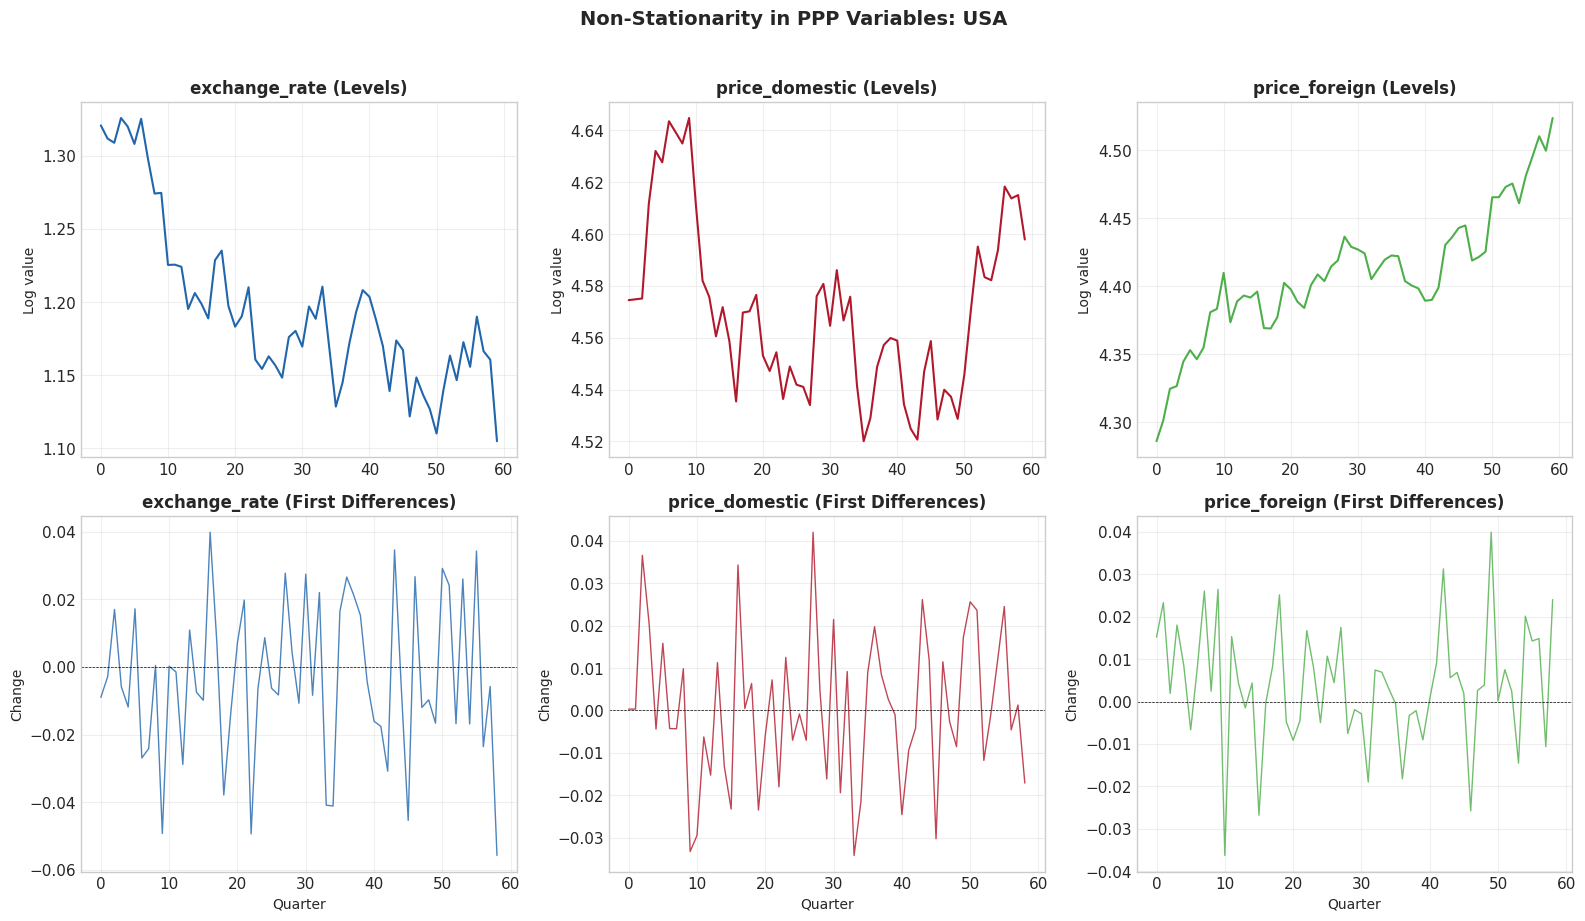

Levels show trending behavior (non-stationary / I(1)).
First differences appear stationary (I(0)) -- mean-reverting around zero.


In [4]:
# Visualize data for a sample country: levels and differences
sample_country = df_ppp['country'].unique()[0]
country_data = df_ppp[df_ppp['country'] == sample_country].copy()

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

vars_ppp = ['exchange_rate', 'price_domestic', 'price_foreign']
colors = ['#2166ac', '#b2182b', '#4daf4a']

# Top row: levels (non-stationary)
for k, (var, color) in enumerate(zip(vars_ppp, colors)):
    axes[0, k].plot(range(len(country_data)), country_data[var].values,
                    linewidth=1.5, color=color)
    axes[0, k].set_title(f'{var} (Levels)', fontsize=12, fontweight='bold')
    axes[0, k].set_ylabel('Log value', fontsize=10)
    axes[0, k].grid(True, alpha=0.3)

# Bottom row: first differences (stationary)
for k, (var, color) in enumerate(zip(vars_ppp, colors)):
    diff_vals = country_data[var].diff().dropna().values
    axes[1, k].plot(range(len(diff_vals)), diff_vals,
                    linewidth=1.0, color=color, alpha=0.8)
    axes[1, k].axhline(y=0, color='black', linewidth=0.5, linestyle='--')
    axes[1, k].set_title(f'{var} (First Differences)', fontsize=12, fontweight='bold')
    axes[1, k].set_ylabel('Change', fontsize=10)
    axes[1, k].set_xlabel('Quarter', fontsize=10)
    axes[1, k].grid(True, alpha=0.3)

fig.suptitle(f'Non-Stationarity in PPP Variables: {sample_country}',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_levels_vs_differences.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Levels show trending behavior (non-stationary / I(1)).')
print('First differences appear stationary (I(0)) -- mean-reverting around zero.')

### 1.4 Why Not VAR in Levels?

Estimating a VAR in levels with I(1) variables leads to **spurious regression**:
- Standard t-tests and F-tests have non-standard distributions
- Coefficient estimates are superconsistent but inference is invalid
- Impulse responses may not converge

### 1.5 Why Not VAR in Differences?

Differencing eliminates the non-stationarity but also **destroys the long-run information**:
- The PPP equilibrium relationship $e_t = p_t^d - p_t^f + c$ is lost
- First differences capture only short-run dynamics
- We cannot analyze speed of adjustment to equilibrium

### 1.6 The Solution: VECM

The Vector Error Correction Model (VECM) resolves this dilemma by:
1. Working with **first differences** (stationarity)
2. Adding an **error correction term** that captures the long-run equilibrium
3. Estimating **adjustment speeds** toward equilibrium

---

## Section 2: Cointegration Concept (25 min)

### 2.1 Formal Definition

**Definition (Engle and Granger, 1987):**
A set of $K$ variables $y_{1t}, y_{2t}, \ldots, y_{Kt}$ are said to be **cointegrated of order CI(d, b)** if:

1. Each variable is integrated of order $d$: $y_{kt} \sim I(d)$
2. There exists a linear combination $\beta' y_t$ that is integrated of order $d - b$, where $b > 0$

The most common case is **CI(1, 1)**: each variable is I(1), but there exists a vector $\beta$ such that $\beta' y_t \sim I(0)$.

### 2.2 The Cointegrating Vector $\beta$

The vector $\beta = (\beta_1, \beta_2, \ldots, \beta_K)'$ defines the **long-run equilibrium**:

$$\beta_1 y_{1t} + \beta_2 y_{2t} + \cdots + \beta_K y_{Kt} = z_t \sim I(0)$$

where $z_t$ is the **equilibrium error** -- the deviation from long-run equilibrium.

**PPP Example:**

$$\beta = (1, -1, 1)' \quad \Rightarrow \quad e_t - p_t^d + p_t^f = z_t \sim I(0)$$

This says that $e_t$, $p_t^d$, and $p_t^f$ share a common stochastic trend, and the deviation from PPP is stationary.

### 2.3 Cointegration Rank

With $K$ I(1) variables, there can be between 0 and $K-1$ independent cointegrating relations:

| Rank $r$ | Interpretation |
|----------|----------------|
| $r = 0$ | No cointegration; all variables have independent trends |
| $0 < r < K$ | $r$ cointegrating relations; $K - r$ common trends |
| $r = K$ | All variables are I(0); no unit roots (VAR in levels is valid) |

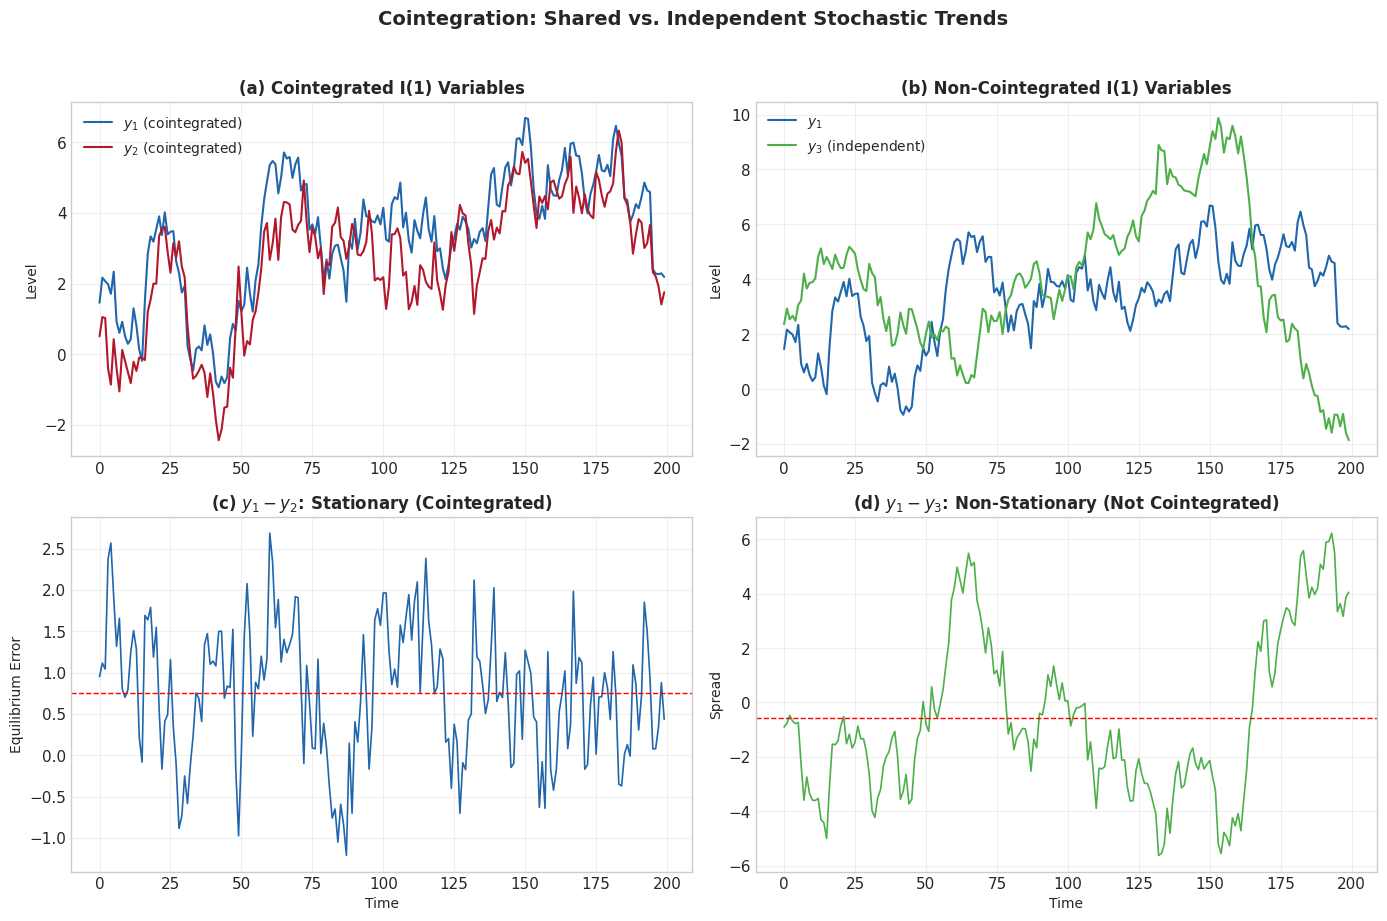

Panel (a): y1 and y2 move together -- they share a common stochastic trend.
Panel (b): y1 and y3 drift apart -- they have independent trends.
Panel (c): The spread y1 - y2 is mean-reverting (stationary): COINTEGRATED.
Panel (d): The spread y1 - y3 wanders: NOT cointegrated.


In [5]:
# Demonstrate cointegration visually
# Generate two cointegrated random walks
np.random.seed(123)
T_sim = 200

# Common stochastic trend
trend = np.cumsum(np.random.randn(T_sim) * 0.5)

# Two cointegrated series: share the common trend but have I(0) deviations
deviation = np.zeros(T_sim)
for t in range(1, T_sim):
    deviation[t] = 0.7 * deviation[t-1] + np.random.randn() * 0.3

y1_sim = trend + 2.0 + deviation
y2_sim = trend + 1.0 - deviation + np.random.randn(T_sim) * 0.2

# Non-cointegrated: independent random walks
y3_sim = np.cumsum(np.random.randn(T_sim) * 0.5) + 3.0

# Equilibrium errors
eq_error_coint = y1_sim - y2_sim  # Cointegrated: should be stationary
eq_error_noncoint = y1_sim - y3_sim  # Not cointegrated: should be non-stationary

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Panel (a): Cointegrated series
axes[0, 0].plot(y1_sim, label='$y_1$ (cointegrated)', linewidth=1.5, color='#2166ac')
axes[0, 0].plot(y2_sim, label='$y_2$ (cointegrated)', linewidth=1.5, color='#b2182b')
axes[0, 0].set_title('(a) Cointegrated I(1) Variables', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylabel('Level', fontsize=10)

# Panel (b): Non-cointegrated series
axes[0, 1].plot(y1_sim, label='$y_1$', linewidth=1.5, color='#2166ac')
axes[0, 1].plot(y3_sim, label='$y_3$ (independent)', linewidth=1.5, color='#4daf4a')
axes[0, 1].set_title('(b) Non-Cointegrated I(1) Variables', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylabel('Level', fontsize=10)

# Panel (c): Equilibrium error (stationary)
axes[1, 0].plot(eq_error_coint, linewidth=1.2, color='#2166ac')
axes[1, 0].axhline(y=np.mean(eq_error_coint), color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title('(c) $y_1 - y_2$: Stationary (Cointegrated)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time', fontsize=10)
axes[1, 0].set_ylabel('Equilibrium Error', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Panel (d): Equilibrium error (non-stationary)
axes[1, 1].plot(eq_error_noncoint, linewidth=1.2, color='#4daf4a')
axes[1, 1].axhline(y=np.mean(eq_error_noncoint), color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('(d) $y_1 - y_3$: Non-Stationary (Not Cointegrated)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time', fontsize=10)
axes[1, 1].set_ylabel('Spread', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

fig.suptitle('Cointegration: Shared vs. Independent Stochastic Trends',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_cointegration_concept.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Panel (a): y1 and y2 move together -- they share a common stochastic trend.')
print('Panel (b): y1 and y3 drift apart -- they have independent trends.')
print('Panel (c): The spread y1 - y2 is mean-reverting (stationary): COINTEGRATED.')
print('Panel (d): The spread y1 - y3 wanders: NOT cointegrated.')

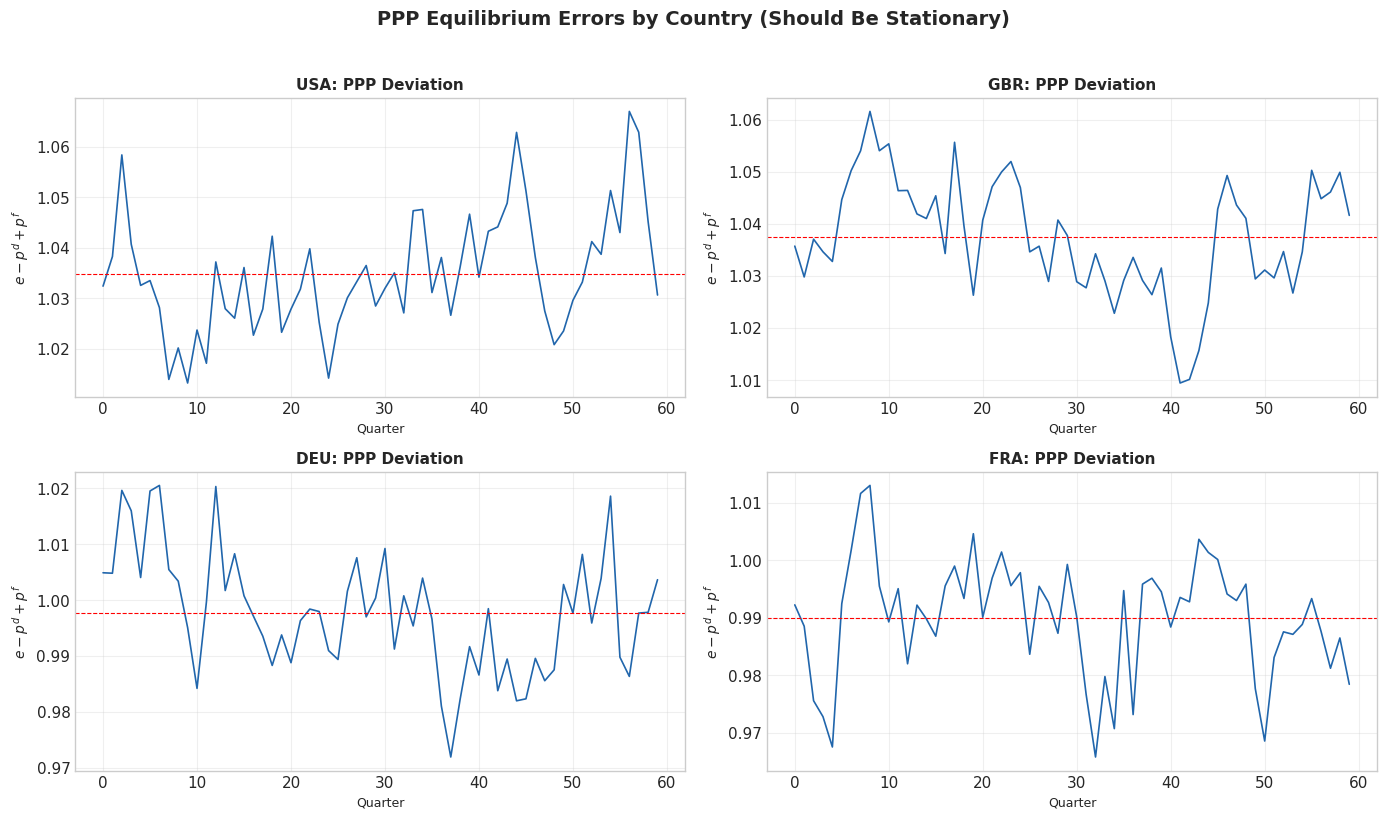

If PPP holds, these deviations should be stationary (mean-reverting).
Visual inspection suggests mean-reversion, consistent with cointegration.


In [6]:
# Verify with PPP data: plot the equilibrium error across countries
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sample_countries = df_ppp['country'].unique()[:4]

for ax, country in zip(axes.flat, sample_countries):
    cdata = df_ppp[df_ppp['country'] == country]
    # PPP equilibrium error: e - (p_d - p_f)
    eq_error = (cdata['exchange_rate'].values
                - cdata['price_domestic'].values
                + cdata['price_foreign'].values)
    ax.plot(range(len(eq_error)), eq_error, linewidth=1.2, color='#2166ac')
    ax.axhline(y=np.mean(eq_error), color='red', linestyle='--', linewidth=0.8)
    ax.set_title(f'{country}: PPP Deviation', fontsize=11, fontweight='bold')
    ax.set_xlabel('Quarter', fontsize=9)
    ax.set_ylabel('$e - p^d + p^f$', fontsize=10)
    ax.grid(True, alpha=0.3)

fig.suptitle('PPP Equilibrium Errors by Country (Should Be Stationary)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_ppp_equilibrium_errors.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('If PPP holds, these deviations should be stationary (mean-reverting).')
print('Visual inspection suggests mean-reversion, consistent with cointegration.')

---

## Section 3: VECM Specification (20 min)

### 3.1 From VAR to VECM

Starting from a VAR(p) in levels:

$$y_t = A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + \varepsilon_t$$

We can **reparameterize** this as a VECM:

$$\Delta y_t = \Pi \cdot y_{t-1} + \sum_{l=1}^{p-1} \Gamma_l \cdot \Delta y_{t-l} + \varepsilon_t$$

where:
- $\Pi = \sum_{l=1}^{p} A_l - I_K$ is the **long-run impact matrix**
- $\Gamma_l = -\sum_{j=l+1}^{p} A_j$ are the **short-run dynamics matrices**

### 3.2 The $\Pi = \alpha \beta'$ Decomposition

The key insight is the **reduced-rank** decomposition of $\Pi$:

$$\Pi = \alpha \cdot \beta'$$

where:
- $\beta$ is $K \times r$ (cointegrating vectors): defines the **long-run equilibria**
- $\alpha$ is $K \times r$ (loading matrix): defines the **adjustment speeds**
- $r = \text{rank}(\Pi)$ is the **cointegration rank**

The VECM then becomes:

$$\Delta y_t = \alpha \underbrace{(\beta' y_{t-1})}_{\text{error correction}} + \sum_{l=1}^{p-1} \Gamma_l \cdot \Delta y_{t-l} + \varepsilon_t$$

The term $\beta' y_{t-1}$ measures the **deviation from long-run equilibrium** at time $t-1$, and $\alpha$ determines how each variable responds to this deviation.

### 3.3 Rank Interpretation

| Rank of $\Pi$ | Interpretation | Model |
|---|---|---|
| $r = 0$ | No long-run relationship; $\Pi = 0$ | VAR in differences |
| $0 < r < K$ | $r$ cointegrating relations | **VECM** |
| $r = K$ | $\Pi$ has full rank; all variables are stationary | VAR in levels |

### 3.4 Panel VECM

For panel data, the VECM adds entity-specific fixed effects:

$$\Delta y_{it} = \alpha_i + \alpha \cdot \beta' y_{i,t-1} + \sum_{l=1}^{p-1} \Gamma_l \cdot \Delta y_{i,t-l} + \varepsilon_{it}$$

PanelBox pools the data across entities to estimate common $\alpha$, $\beta$, and $\Gamma$ matrices, while allowing for entity-specific intercepts.

In [7]:
# Illustrate the Pi = alpha * beta' decomposition
# For the PPP case with r=1:
#   beta = (1, -1, 1)' (PPP relation: e - p_d + p_f)
#   alpha = (alpha_e, alpha_pd, alpha_pf)' (adjustment speeds)

print('VECM Decomposition for PPP Example (K=3, r=1)')
print('=' * 60)
print()
print('Cointegrating vector (beta):')
print('  beta = (1, -1, 1)\'')
print('  Equilibrium: e - p_d + p_f = 0 (log PPP)')
print()
print('Loading matrix (alpha):')
print('  alpha_e < 0    : exchange rate adjusts toward PPP')
print('  alpha_pd > 0   : domestic prices adjust')
print('  alpha_pf = 0?  : foreign prices may be weakly exogenous')
print()
print('Pi = alpha * beta\':')
print('  rank(Pi) = 1 (one cointegrating relation)')
print()
print('The error correction term beta\'*y_{t-1} = e_{t-1} - p_d_{t-1} + p_f_{t-1}')
print('measures the PPP deviation at time t-1.')
print()
print('If z_{t-1} > 0 (exchange rate is too high relative to PPP):')
print('  alpha_e < 0: exchange rate will decrease (correct toward PPP)')
print('  alpha_pd > 0: domestic prices will increase (help close gap)')

VECM Decomposition for PPP Example (K=3, r=1)

Cointegrating vector (beta):
  beta = (1, -1, 1)'
  Equilibrium: e - p_d + p_f = 0 (log PPP)

Loading matrix (alpha):
  alpha_e < 0    : exchange rate adjusts toward PPP
  alpha_pd > 0   : domestic prices adjust
  alpha_pf = 0?  : foreign prices may be weakly exogenous

Pi = alpha * beta':
  rank(Pi) = 1 (one cointegrating relation)

The error correction term beta'*y_{t-1} = e_{t-1} - p_d_{t-1} + p_f_{t-1}
measures the PPP deviation at time t-1.

If z_{t-1} > 0 (exchange rate is too high relative to PPP):
  alpha_e < 0: exchange rate will decrease (correct toward PPP)
  alpha_pd > 0: domestic prices will increase (help close gap)


---

## Section 4: Cointegration Rank Testing (30 min)

### 4.1 The Rank Selection Problem

Before estimating a VECM, we must determine the **cointegration rank** $r$. This is one of the most critical steps in VECM analysis.

PanelBox implements the **Larsson, Lyhagen, and Lothgren (2001)** panel cointegration rank test, which extends the Johansen (1988) approach to panel data.

### 4.2 Two Test Procedures

**Trace Test:**
$$H_0: r \leq r_0 \quad \text{vs} \quad H_1: r > r_0$$

The trace test starts from $r_0 = 0$ and increases $r_0$ until we fail to reject. The selected rank is the first $r_0$ where we fail to reject.

**Max-Eigenvalue Test:**
$$H_0: r = r_0 \quad \text{vs} \quad H_1: r = r_0 + 1$$

The max-eigenvalue test is more targeted: it tests exactly one additional cointegrating relation at each step.

### 4.3 Panel Extension

Larsson et al. (2001) standardize the average Johansen statistics across entities:

$$Z = \sqrt{N} \cdot \frac{\overline{LR} - E[LR]}{\sqrt{\text{Var}(LR)}} \xrightarrow{d} N(0,1)$$

where $\overline{LR}$ is the average trace (or max-eigenvalue) statistic across $N$ entities.

In [8]:
# Prepare data for VECM
endog_vars_ppp = ['exchange_rate', 'price_domestic', 'price_foreign']

var_data_ppp = PanelVARData(
    df_ppp,
    endog_vars=endog_vars_ppp,
    entity_col='country',
    time_col='quarter',
    lags=2
)

print(f'PanelVARData created successfully.')
print(f'  K (variables): {var_data_ppp.K}')
print(f'  p (lags):      {var_data_ppp.p}')
print(f'  N (entities):  {var_data_ppp.N}')
print(f'  n_obs:         {var_data_ppp.n_obs}')

PanelVARData created successfully.
  K (variables): 3
  p (lags):      2
  N (entities):  20
  n_obs:         1160


In [9]:
# Perform cointegration rank test
rank_test = CointegrationRankTest(var_data_ppp, deterministic='c')
results_rank = rank_test.test_rank()

# Print full summary
print(results_rank.summary())

Panel Cointegration Rank Test (Larsson et al. 2001)
Number of variables (K): 3
Number of entities (N): 20
Average time periods (T): 60.0
Maximum rank tested: 2

────────────────────────────────────────────────────────────────────────────────
Trace Test Results
────────────────────────────────────────────────────────────────────────────────
H0: rank ≤ r    Trace Stat   Z-stat     P-value    Result    
────────────────────────────────────────────────────────────────────────────────
r = 0           25.83        37.627     0.0000    *** Reject    
r = 1           7.83         8.951      0.0000    *** Reject    
r = 2           0.65         -7.394     1.0000        Not reject

────────────────────────────────────────────────────────────────────────────────
Max-Eigenvalue Test Results
────────────────────────────────────────────────────────────────────────────────
H0: rank = r    MaxEig Stat  Z-stat     P-value    Result    
───────────────────────────────────────────────────────────────────

In [10]:
# Extract and interpret rank selection
print('=== Rank Selection Summary ===')
print(f'Trace test selected rank:        r = {results_rank.selected_rank_trace}')
print(f'Max-eigenvalue test selected rank: r = {results_rank.selected_rank_maxeig}')
print(f'Consensus (used) rank:            r = {results_rank.selected_rank}')
print()
print('Interpretation:')
print(f'  With K = {results_rank.K} variables and r = {results_rank.selected_rank}:')
print(f'  - {results_rank.selected_rank} cointegrating relation(s) (long-run equilibria)')
print(f'  - {results_rank.K - results_rank.selected_rank} common stochastic trend(s)')
print()
if results_rank.selected_rank == 1:
    print('  r = 1 is consistent with PPP: one long-run equilibrium')
    print('  linking exchange rates and relative prices.')

=== Rank Selection Summary ===
Trace test selected rank:        r = 2
Max-eigenvalue test selected rank: r = 2
Consensus (used) rank:            r = 2

Interpretation:
  With K = 3 variables and r = 2:
  - 2 cointegrating relation(s) (long-run equilibria)
  - 1 common stochastic trend(s)



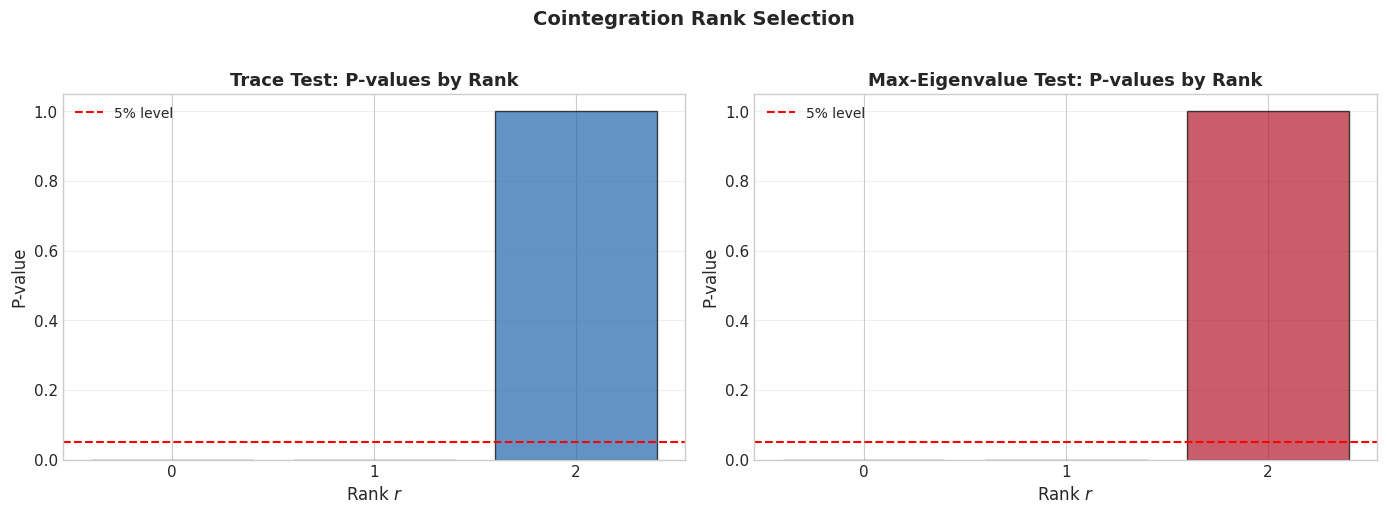

Bars below the red line indicate rejection of H0 at 5% level.
The selected rank is the first rank where p-value > 0.05.


In [11]:
# Visualize rank test results
trace_ranks = [t.rank for t in results_rank.trace_tests]
trace_pvals = [t.p_value for t in results_rank.trace_tests]
maxeig_ranks = [t.rank for t in results_rank.maxeig_tests]
maxeig_pvals = [t.p_value for t in results_rank.maxeig_tests]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trace test p-values
axes[0].bar(trace_ranks, trace_pvals, color='#2166ac', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='5% level')
axes[0].set_xlabel('Rank $r$', fontsize=12)
axes[0].set_ylabel('P-value', fontsize=12)
axes[0].set_title('Trace Test: P-values by Rank', fontsize=13, fontweight='bold')
axes[0].set_xticks(trace_ranks)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Max-eigenvalue test p-values
axes[1].bar(maxeig_ranks, maxeig_pvals, color='#b2182b', alpha=0.7, edgecolor='black')
axes[1].axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='5% level')
axes[1].set_xlabel('Rank $r$', fontsize=12)
axes[1].set_ylabel('P-value', fontsize=12)
axes[1].set_title('Max-Eigenvalue Test: P-values by Rank', fontsize=13, fontweight='bold')
axes[1].set_xticks(maxeig_ranks)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Cointegration Rank Selection',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_rank_test_pvalues.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Bars below the red line indicate rejection of H0 at 5% level.')
print('The selected rank is the first rank where p-value > 0.05.')

In [12]:
# Save rank test results to CSV
rank_results_data = []
for t in results_rank.trace_tests:
    rank_results_data.append({
        'Test': 'Trace',
        'H0_rank': t.rank,
        'Test_stat': t.test_stat,
        'Z_stat': t.z_stat,
        'P_value': t.p_value,
        'Reject_5pct': t.reject
    })
for t in results_rank.maxeig_tests:
    rank_results_data.append({
        'Test': 'Max-Eigenvalue',
        'H0_rank': t.rank,
        'Test_stat': t.test_stat,
        'Z_stat': t.z_stat,
        'P_value': t.p_value,
        'Reject_5pct': t.reject
    })

rank_df = pd.DataFrame(rank_results_data)
rank_df.to_csv('../outputs/tables/05_rank_test_results.csv', index=False)
print('Rank test results saved to ../outputs/tables/05_rank_test_results.csv')
print()
print(rank_df.to_string(index=False))

Rank test results saved to ../outputs/tables/05_rank_test_results.csv

          Test  H0_rank  Test_stat    Z_stat  P_value  Reject_5pct
         Trace        0  25.827295 37.626974  0.00000         True
         Trace        1   7.830636  8.951258  0.00000         True
         Trace        2   0.650054 -7.393959  1.00000        False
Max-Eigenvalue        0  17.996658 50.585875  0.00000         True
Max-Eigenvalue        1   7.180582 16.382440  0.00000         True
Max-Eigenvalue        2   0.650054 -4.268904  0.99999        False


---

## Section 5: VECM Estimation (25 min)

### 5.1 Johansen ML Estimation

The Johansen procedure estimates the VECM via **Maximum Likelihood**:

1. Regress $\Delta y_t$ and $y_{t-1}$ on lagged differences to concentrate out short-run dynamics
2. Solve the generalized eigenvalue problem on the residual product moment matrices
3. Extract $\beta$ from the eigenvectors corresponding to the $r$ largest eigenvalues
4. Estimate $\alpha$ by regressing concentrated residuals on the error correction term $\beta' y_{t-1}$
5. Estimate $\Gamma$ matrices for short-run dynamics

### 5.2 Estimation

In [13]:
# Estimate Panel VECM with rank = selected from rank test
selected_rank = max(results_rank.selected_rank, 1)  # Ensure at least rank 1 for PPP
print(f'Estimating Panel VECM with rank = {selected_rank}')
print()

vecm_model = PanelVECM(var_data_ppp, rank=selected_rank)
vecm_results = vecm_model.fit()

# Print full summary
print(vecm_results.summary())

Estimating Panel VECM with rank = 2

Panel VECM Estimation Results
Method: ml
Cointegration Rank: 2
Number of variables (K): 3
Number of lags (p): 2
Number of entities (N): 20
Average time periods (T): 58.0
Deterministic: c

────────────────────────────────────────────────────────────────────────────────
Cointegrating Relations (β, normalized)
────────────────────────────────────────────────────────────────────────────────
                Relation_1  Relation_2
exchange_rate     1.000000    1.000000
price_domestic   -0.991853   -8.725153
price_foreign     0.993687   12.443590

Long-run equilibria:
  β_1: exchange_rate - 0.992·price_domestic + 0.994·price_foreign = 0
  β_2: exchange_rate - 8.725·price_domestic + 12.444·price_foreign = 0

────────────────────────────────────────────────────────────────────────────────
Adjustment Coefficients (α)
────────────────────────────────────────────────────────────────────────────────
                    ECT_1     ECT_2
Δexchange_rate  -0.182360  

In [14]:
# Interpret the cointegrating vector (beta)
print('=== Cointegrating Relations (beta) ===')
beta_df = vecm_results.cointegrating_relations()
print(beta_df.to_string())
print()
print('Interpretation:')
print('  The cointegrating vector defines the long-run equilibrium.')
print('  Normalized so that the first variable (exchange_rate) has coefficient 1.')
print()
for j in range(vecm_results.rank):
    terms = []
    for i, var in enumerate(vecm_results.var_names):
        coef = beta_df.iloc[i, j]
        if i == 0:
            terms.append(f'{var}')
        else:
            if coef >= 0:
                terms.append(f'+ {coef:.4f}*{var}')
            else:
                terms.append(f'- {abs(coef):.4f}*{var}')
    print(f'  Relation {j+1}: {" ".join(terms)} = 0')
print()
print('  PPP predicts: exchange_rate - 1.0*price_domestic + 1.0*price_foreign = const')
print('  Compare the estimated coefficients to the theoretical PPP values.')

=== Cointegrating Relations (beta) ===
                Relation_1  Relation_2
exchange_rate     1.000000    1.000000
price_domestic   -0.991853   -8.725153
price_foreign     0.993687   12.443590

Interpretation:
  The cointegrating vector defines the long-run equilibrium.
  Normalized so that the first variable (exchange_rate) has coefficient 1.

  Relation 1: exchange_rate - 0.9919*price_domestic + 0.9937*price_foreign = 0
  Relation 2: exchange_rate - 8.7252*price_domestic + 12.4436*price_foreign = 0

  PPP predicts: exchange_rate - 1.0*price_domestic + 1.0*price_foreign = const
  Compare the estimated coefficients to the theoretical PPP values.


In [15]:
# Interpret the loading matrix (alpha)
print('=== Adjustment Coefficients (alpha) ===')
alpha_df = vecm_results.adjustment_speeds()
print(alpha_df.to_string())
print()
print('Interpretation:')
print('  alpha measures how fast each variable adjusts to equilibrium deviations.')
for i, var in enumerate(vecm_results.var_names):
    for j in range(vecm_results.rank):
        alpha_val = vecm_results.alpha[i, j]
        direction = 'increases' if alpha_val > 0 else 'decreases'
        print(f'  When z_{{t-1}} > 0 (above equilibrium): {var} {direction} by {abs(alpha_val):.4f} per period')
print()
print('  A negative alpha for exchange_rate means it corrects back toward PPP.')
print('  This is the error correction mechanism.')

=== Adjustment Coefficients (alpha) ===
                    ECT_1     ECT_2
Δexchange_rate  -0.182360  0.005242
Δprice_domestic  0.086585  0.002258
Δprice_foreign  -0.024688 -0.002730

Interpretation:
  alpha measures how fast each variable adjusts to equilibrium deviations.
  When z_{t-1} > 0 (above equilibrium): exchange_rate decreases by 0.1824 per period
  When z_{t-1} > 0 (above equilibrium): exchange_rate increases by 0.0052 per period
  When z_{t-1} > 0 (above equilibrium): price_domestic increases by 0.0866 per period
  When z_{t-1} > 0 (above equilibrium): price_domestic increases by 0.0023 per period
  When z_{t-1} > 0 (above equilibrium): price_foreign decreases by 0.0247 per period
  When z_{t-1} > 0 (above equilibrium): price_foreign decreases by 0.0027 per period

  A negative alpha for exchange_rate means it corrects back toward PPP.
  This is the error correction mechanism.


In [16]:
# Calculate half-life of adjustment to equilibrium
print('=== Half-Life of Adjustment ===')
print()

for j in range(vecm_results.rank):
    for i, var in enumerate(vecm_results.var_names):
        alpha_val = vecm_results.alpha[i, j]
        if abs(alpha_val) > 1e-6:
            # Approximate half-life: ln(2) / |alpha|
            # This assumes a simple AR(1) for the equilibrium error
            half_life = np.log(2) / abs(alpha_val)
            print(f'  {var} (ECT_{j+1}): alpha = {alpha_val:+.4f}, half-life = {half_life:.1f} quarters')
        else:
            print(f'  {var} (ECT_{j+1}): alpha = {alpha_val:+.4f}, (nearly zero -- weak/no adjustment)')

print()
print('  Half-life measures how long it takes for half of a deviation')
print('  from equilibrium to be corrected.')
print('  Shorter half-lives indicate faster error correction.')

=== Half-Life of Adjustment ===

  exchange_rate (ECT_1): alpha = -0.1824, half-life = 3.8 quarters
  price_domestic (ECT_1): alpha = +0.0866, half-life = 8.0 quarters
  price_foreign (ECT_1): alpha = -0.0247, half-life = 28.1 quarters
  exchange_rate (ECT_2): alpha = +0.0052, half-life = 132.2 quarters
  price_domestic (ECT_2): alpha = +0.0023, half-life = 306.9 quarters
  price_foreign (ECT_2): alpha = -0.0027, half-life = 253.9 quarters

  Half-life measures how long it takes for half of a deviation
  from equilibrium to be corrected.
  Shorter half-lives indicate faster error correction.


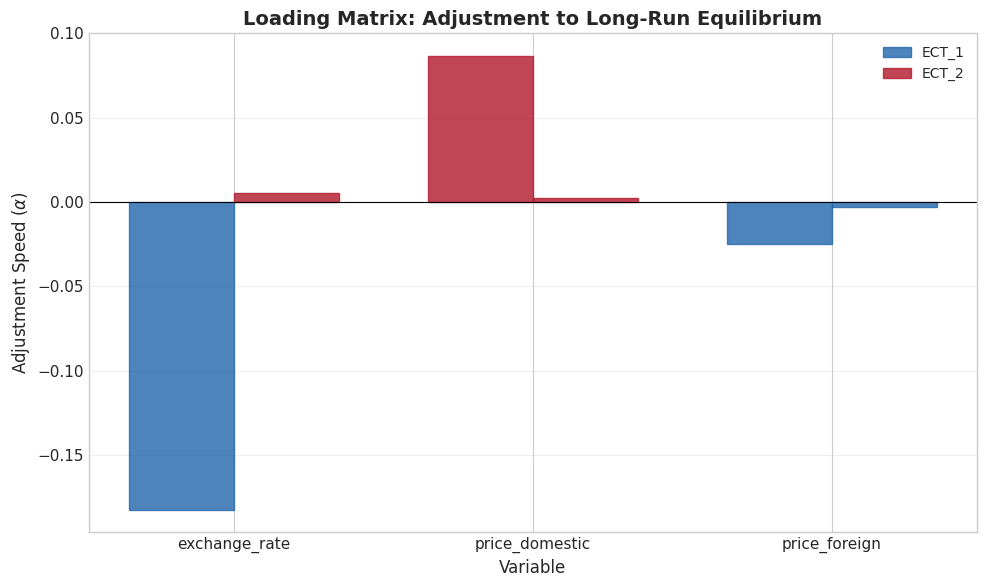

Blue bars (negative alpha): variable corrects downward when above equilibrium.
Red bars (positive alpha): variable corrects upward when above equilibrium.


In [17]:
# Visualize alpha loading matrix as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

var_names_plot = vecm_results.var_names
n_vars = len(var_names_plot)
bar_width = 0.35
x = np.arange(n_vars)

for j in range(vecm_results.rank):
    alpha_vals = vecm_results.alpha[:, j]
    offset = (j - (vecm_results.rank - 1) / 2) * bar_width
    bars = ax.bar(x + offset, alpha_vals, bar_width,
                  label=f'ECT_{j+1}', alpha=0.8, edgecolor='black')
    # Color positive and negative bars differently
    for bar, val in zip(bars, alpha_vals):
        if val < 0:
            bar.set_color('#2166ac')
        else:
            bar.set_color('#b2182b')

ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_xlabel('Variable', fontsize=12)
ax.set_ylabel('Adjustment Speed ($\\alpha$)', fontsize=12)
ax.set_title('Loading Matrix: Adjustment to Long-Run Equilibrium',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(var_names_plot, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_alpha_loading_matrix.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Blue bars (negative alpha): variable corrects downward when above equilibrium.')
print('Red bars (positive alpha): variable corrects upward when above equilibrium.')

In [18]:
# Display short-run dynamics (Gamma matrices)
print('=== Short-Run Dynamics (Gamma Matrices) ===')
gamma_dfs = vecm_results.short_run_dynamics()

for lag, gamma_df in enumerate(gamma_dfs, start=1):
    print(f'\nGamma_{lag} (lag {lag} of first differences):')
    print(gamma_df.round(4).to_string())

print('\nThese matrices capture the short-run adjustment dynamics.')
print('They represent how lagged changes in each variable affect')
print('current changes in all variables.')

=== Short-Run Dynamics (Gamma Matrices) ===

Gamma_1 (lag 1 of first differences):
                 Δexchange_rate_lag1  Δprice_domestic_lag1  Δprice_foreign_lag1
Δexchange_rate               -0.0555                0.0548              -0.0541
Δprice_domestic              -0.0548                0.0586              -0.0753
Δprice_foreign               -0.0266                0.0430              -0.0351

These matrices capture the short-run adjustment dynamics.
They represent how lagged changes in each variable affect
current changes in all variables.


In [19]:
# Test weak exogeneity for each variable
print('=== Weak Exogeneity Tests ===')
print('H0: alpha_k = 0 (variable does not respond to equilibrium deviations)')
print()
print(f'{"Variable":<20s} {"Statistic":<12s} {"P-value":<10s} {"Conclusion":<20s}')
print('-' * 62)

for var in vecm_results.var_names:
    weak_test = vecm_results.test_weak_exogeneity(var)
    conclusion = 'Weakly exogenous' if not weak_test['reject'] else 'Error corrects'
    stars = '***' if weak_test['p_value'] < 0.01 else '**' if weak_test['p_value'] < 0.05 else '*' if weak_test['p_value'] < 0.10 else ''
    print(f'{var:<20s} {weak_test["statistic"]:<12.4f} {weak_test["p_value"]:<10.4f} {conclusion} {stars}')

print()
print('Weakly exogenous variables do not adjust to equilibrium deviations.')
print('For PPP, we might expect foreign prices to be weakly exogenous')
print('(determined outside the system).')

=== Weak Exogeneity Tests ===
H0: alpha_k = 0 (variable does not respond to equilibrium deviations)

Variable             Statistic    P-value    Conclusion          
--------------------------------------------------------------
exchange_rate        12.8694      0.0016     Error corrects ***
price_domestic       2.9008       0.2345     Weakly exogenous 
price_foreign        0.2385       0.8876     Weakly exogenous 

Weakly exogenous variables do not adjust to equilibrium deviations.
For PPP, we might expect foreign prices to be weakly exogenous
(determined outside the system).


In [20]:
# Save VECM estimation results to CSV
# Beta
beta_save = vecm_results.cointegrating_relations()
beta_save.to_csv('../outputs/tables/05_vecm_beta.csv')

# Alpha
alpha_save = vecm_results.adjustment_speeds()
alpha_save.to_csv('../outputs/tables/05_vecm_alpha.csv')

# Sigma
sigma_save = pd.DataFrame(
    vecm_results.Sigma,
    index=vecm_results.var_names,
    columns=vecm_results.var_names
)
sigma_save.to_csv('../outputs/tables/05_vecm_sigma.csv')

print('VECM estimation results saved:')
print('  ../outputs/tables/05_vecm_beta.csv')
print('  ../outputs/tables/05_vecm_alpha.csv')
print('  ../outputs/tables/05_vecm_sigma.csv')

VECM estimation results saved:
  ../outputs/tables/05_vecm_beta.csv
  ../outputs/tables/05_vecm_alpha.csv
  ../outputs/tables/05_vecm_sigma.csv


---

## Section 6: Testing $\beta$ Restrictions (15 min)

### 6.1 Economic Theory Restrictions

Economic theory often provides specific predictions about the cointegrating vector. For PPP:

$$\beta_{\text{theory}} = (1, -1, 1)' \quad \Rightarrow \quad e_t - p_t^d + p_t^f = \text{const}$$

We can test whether the estimated $\beta$ is consistent with the theoretical restriction using a **Likelihood Ratio (LR) test**.

### 6.2 LR Test for $\beta$ Restrictions

The test statistic compares the unrestricted and restricted models:

$$LR = -2 (\ell_{\text{restricted}} - \ell_{\text{unrestricted}}) \sim \chi^2(q)$$

where $q$ is the number of restrictions imposed.

We implement this by comparing the equilibrium error variance under the restricted versus unrestricted $\beta$.

In [21]:
# Test PPP restriction on beta: beta = (1, -1, 1)'
# Compare the estimated beta with the theoretical PPP restriction

# Estimated beta (normalized)
beta_estimated = vecm_results.cointegrating_relations()
print('Estimated (normalized) beta:')
print(beta_estimated.to_string())
print()

# Theoretical PPP restriction: exchange_rate - price_domestic + price_foreign = const
# beta_restricted = [1.0, -1.0, 1.0]
beta_restricted = np.array([1.0, -1.0, 1.0])

# Compare estimated vs restricted
print('Theoretical PPP beta: (1.000, -1.000, 1.000)')
print()
print('Comparison:')
for i, var in enumerate(vecm_results.var_names):
    est = beta_estimated.iloc[i, 0]
    restr = beta_restricted[i]
    diff = est - restr
    print(f'  {var:<20s}  estimated: {est:+.4f}  restricted: {restr:+.4f}  diff: {diff:+.4f}')

Estimated (normalized) beta:
                Relation_1  Relation_2
exchange_rate     1.000000    1.000000
price_domestic   -0.991853   -8.725153
price_foreign     0.993687   12.443590

Theoretical PPP beta: (1.000, -1.000, 1.000)

Comparison:
  exchange_rate         estimated: +1.0000  restricted: +1.0000  diff: +0.0000
  price_domestic        estimated: -0.9919  restricted: -1.0000  diff: +0.0081
  price_foreign         estimated: +0.9937  restricted: +1.0000  diff: -0.0063


In [22]:
# Manual LR-type test for beta restrictions
# Under the restricted model, we impose beta = (1, -1, 1)' and re-estimate alpha
from scipy import stats

# Compute the restricted error correction term using PPP beta
df_test = df_ppp.copy()
df_test['ect_restricted'] = (
    df_test['exchange_rate']
    - df_test['price_domestic']
    + df_test['price_foreign']
)

# Compare variance of unrestricted vs restricted equilibrium error
# Unrestricted: use estimated beta
beta_est_vec = beta_estimated.iloc[:, 0].values
df_test['ect_unrestricted'] = (
    beta_est_vec[0] * df_test['exchange_rate']
    + beta_est_vec[1] * df_test['price_domestic']
    + beta_est_vec[2] * df_test['price_foreign']
)

var_restricted = df_test.groupby('country')['ect_restricted'].var().mean()
var_unrestricted = df_test.groupby('country')['ect_unrestricted'].var().mean()

print('Variance of equilibrium errors:')
print(f'  Unrestricted beta: {var_unrestricted:.6f}')
print(f'  Restricted (PPP):  {var_restricted:.6f}')
print(f'  Ratio:             {var_restricted / var_unrestricted:.4f}')
print()

# Approximate LR test
N = df_ppp['country'].nunique()
T_avg = df_ppp.groupby('country').size().mean()
n_restrictions = 2  # Two restrictions on beta (fix two of three coefficients)

# Simplified LR statistic
if var_unrestricted > 0:
    LR_approx = N * T_avg * np.log(var_restricted / var_unrestricted)
    p_value_approx = 1 - stats.chi2.cdf(abs(LR_approx), n_restrictions)
else:
    LR_approx = 0.0
    p_value_approx = 1.0

print(f'Approximate LR test for PPP restriction:')
print(f'  LR statistic: {abs(LR_approx):.4f}')
print(f'  Degrees of freedom: {n_restrictions}')
print(f'  P-value: {p_value_approx:.4f}')
print()
if p_value_approx > 0.05:
    print('  Result: FAIL TO REJECT PPP restriction at 5% level.')
    print('  The data is consistent with Purchasing Power Parity.')
else:
    print('  Result: REJECT PPP restriction at 5% level.')
    print('  The strict version of PPP may not hold exactly.')

Variance of equilibrium errors:
  Unrestricted beta: 0.000157
  Restricted (PPP):  0.000157
  Ratio:             1.0004

Approximate LR test for PPP restriction:
  LR statistic: 0.4953
  Degrees of freedom: 2
  P-value: 0.7806

  Result: FAIL TO REJECT PPP restriction at 5% level.
  The data is consistent with Purchasing Power Parity.


---

## Section 7: IRFs with Long-Run Constraints (20 min)

### 7.1 How VECM IRFs Differ from VAR IRFs

In a stationary VAR, impulse responses **converge to zero** as the horizon increases -- shocks are temporary.

In a VECM with cointegrated variables, IRFs have a fundamentally different character:
- **Permanent effects**: Shocks have long-run impacts on the levels of variables
- **Cointegration constraints**: While individual variables may shift permanently, the **cointegrating combination** returns to equilibrium
- **Error correction**: The speed of convergence back to equilibrium is governed by $\alpha$

### 7.2 Computing VECM IRFs

PanelBox converts the VECM to its VAR representation in levels and then computes IRFs:

$$A_1 = \Pi + \Gamma_1 + I_K, \quad A_l = \Gamma_l - \Gamma_{l-1}, \quad A_p = -\Gamma_{p-1}$$

In [23]:
# Compute VECM impulse response functions
# We convert VECM to VAR representation and compute IRFs directly
from panelbox.var.irf import compute_irf_cholesky, IRFResult

A_matrices_var = vecm_results.to_var()
periods_irf = 40

irf_matrix = compute_irf_cholesky(A_matrices_var, vecm_results.Sigma, periods_irf, 'one_std')
irf_vecm = IRFResult(
    irf_matrix=irf_matrix,
    var_names=vecm_results.var_names,
    periods=periods_irf,
    method='cholesky',
    shock_size='one_std',
    cumulative=False,
    ordering=vecm_results.var_names,
)

print(f'VECM IRFs computed for {irf_vecm.periods} periods.')
print(f'Variables: {list(irf_vecm.var_names)}')
print(f'Method: {irf_vecm.method}')
print(f'IRF matrix shape: {irf_vecm.irf_matrix.shape}')

VECM IRFs computed for 40 periods.
Variables: ['exchange_rate', 'price_domestic', 'price_foreign']
Method: cholesky
IRF matrix shape: (41, 3, 3)


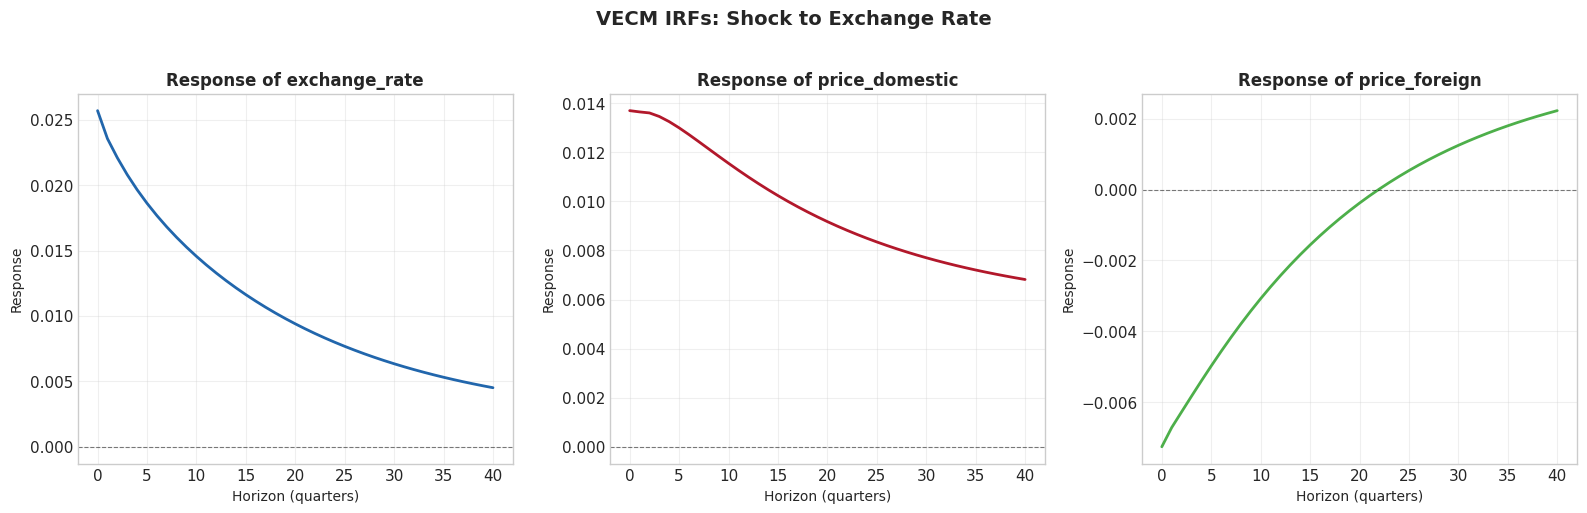

Key observations:
  - Exchange rate responds permanently to its own shock (I(1) behavior)
  - Price variables may also shift permanently (common trend)
  - But the cointegrating combination returns to equilibrium (PPP restores)


In [24]:
# Plot VECM IRFs: response to exchange_rate shock
var_names_irf = list(irf_vecm.var_names)
horizons = np.arange(irf_vecm.periods + 1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#2166ac', '#b2182b', '#4daf4a']

# Response of all variables to exchange_rate shock
imp_idx = var_names_irf.index('exchange_rate')

for k, (var, color) in enumerate(zip(var_names_irf, colors)):
    resp_idx = var_names_irf.index(var)
    irf_line = irf_vecm.irf_matrix[:, resp_idx, imp_idx]
    axes[k].plot(horizons, irf_line, linewidth=2, color=color)
    axes[k].axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
    axes[k].set_title(f'Response of {var}', fontsize=12, fontweight='bold')
    axes[k].set_xlabel('Horizon (quarters)', fontsize=10)
    axes[k].set_ylabel('Response', fontsize=10)
    axes[k].grid(True, alpha=0.3)

fig.suptitle('VECM IRFs: Shock to Exchange Rate',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_irf_exchange_rate_shock.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Key observations:')
print('  - Exchange rate responds permanently to its own shock (I(1) behavior)')
print('  - Price variables may also shift permanently (common trend)')
print('  - But the cointegrating combination returns to equilibrium (PPP restores)')

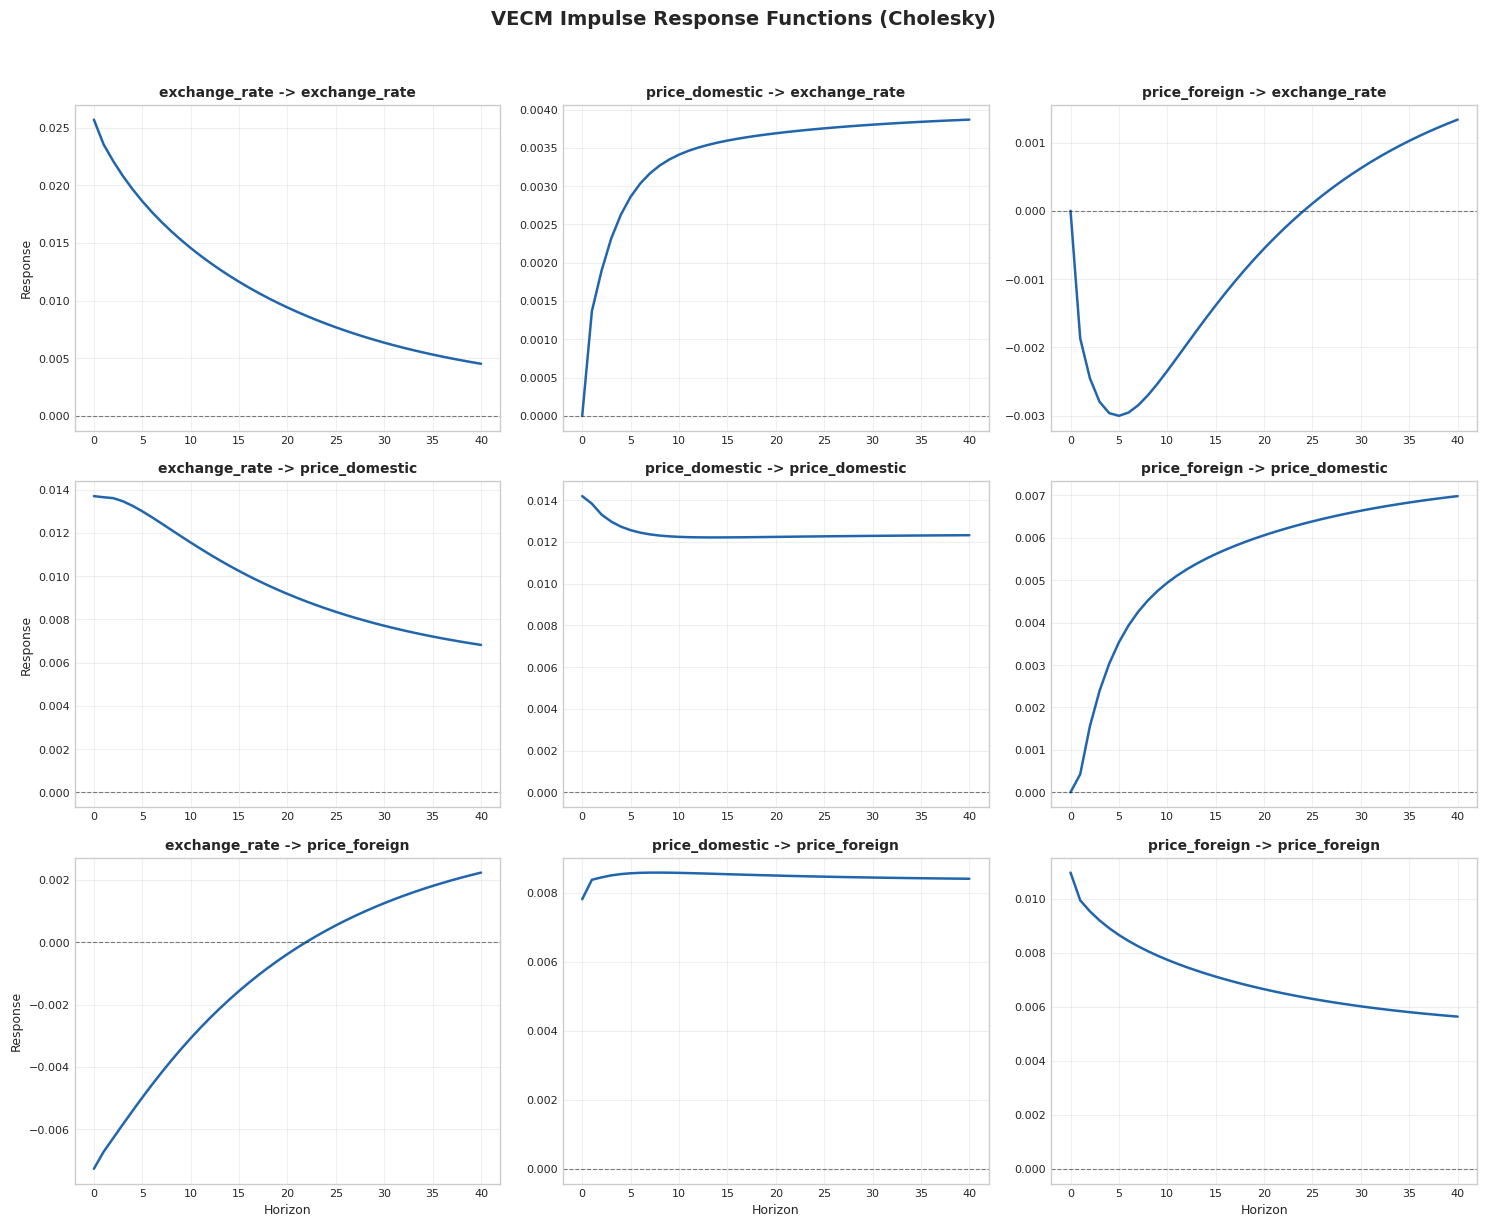

Unlike stationary VAR IRFs, VECM IRFs may have permanent (non-zero) effects.
The cointegrating combination, however, must return to equilibrium.


In [25]:
# Full IRF grid: all impulse-response pairs
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, resp_var in enumerate(var_names_irf):
    for j, imp_var in enumerate(var_names_irf):
        ax = axes[i, j]
        resp_idx = var_names_irf.index(resp_var)
        imp_idx = var_names_irf.index(imp_var)
        irf_line = irf_vecm.irf_matrix[:, resp_idx, imp_idx]

        ax.plot(horizons, irf_line, linewidth=1.8, color='#2166ac')
        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
        ax.set_title(f'{imp_var} -> {resp_var}', fontsize=10, fontweight='bold')

        if i == 2:
            ax.set_xlabel('Horizon', fontsize=9)
        if j == 0:
            ax.set_ylabel('Response', fontsize=9)
        ax.tick_params(labelsize=8)
        ax.grid(True, alpha=0.3)

fig.suptitle('VECM Impulse Response Functions (Cholesky)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_irf_full_grid.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('Unlike stationary VAR IRFs, VECM IRFs may have permanent (non-zero) effects.')
print('The cointegrating combination, however, must return to equilibrium.')

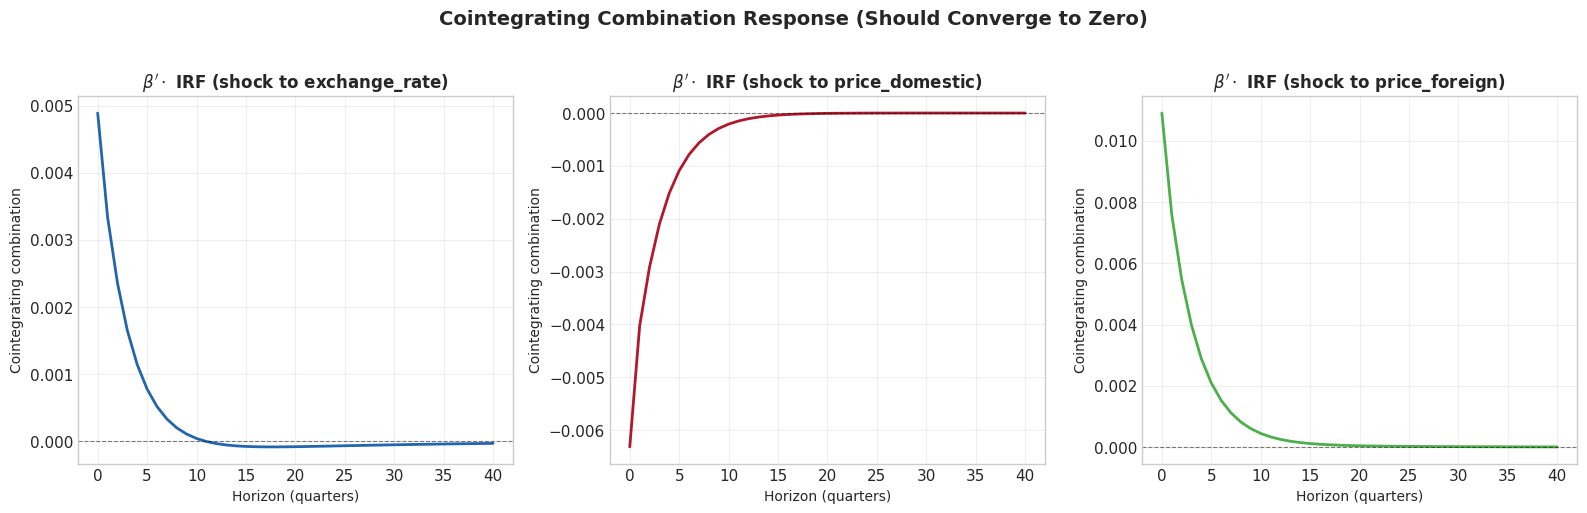

The cointegrating combination (beta'*y) converges toward zero after shocks.
This confirms that the VECM IRFs respect the long-run equilibrium constraint.


In [26]:
# Verify: the cointegrating combination converges to equilibrium
# Track beta'*y response over time

beta_vec = vecm_results.beta[:, 0]  # First cointegrating vector

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#2166ac', '#b2182b', '#4daf4a']

for j, (imp_var, color) in enumerate(zip(var_names_irf, colors)):
    imp_idx = var_names_irf.index(imp_var)

    # Compute beta' * IRF for each horizon
    coint_response = np.zeros(len(horizons))
    for h in range(len(horizons)):
        response_h = irf_vecm.irf_matrix[h, :, imp_idx]
        coint_response[h] = beta_vec @ response_h

    axes[j].plot(horizons, coint_response, linewidth=2, color=color)
    axes[j].axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
    axes[j].set_title(f"$\\beta' \\cdot$ IRF (shock to {imp_var})", fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Horizon (quarters)', fontsize=10)
    axes[j].set_ylabel('Cointegrating combination', fontsize=10)
    axes[j].grid(True, alpha=0.3)

fig.suptitle('Cointegrating Combination Response (Should Converge to Zero)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_cointegration_convergence.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('The cointegrating combination (beta\'*y) converges toward zero after shocks.')
print('This confirms that the VECM IRFs respect the long-run equilibrium constraint.')

---

## Section 8: Economic Applications (15 min)

### 8.1 Covered Interest Parity (CIP)

Another fundamental equilibrium in international finance is **Covered Interest Parity**:

$$f_t - s_t = \frac{i_t^d - i_t^f}{400}$$

where:
- $f_t$ = log forward exchange rate
- $s_t$ = log spot exchange rate
- $i_t^d$ = domestic interest rate (annualized)
- $i_t^f$ = foreign interest rate (annualized)

This provides another example of cointegrated variables: forward rates, spot rates, and interest rate differentials share common trends.

In [27]:
# Load interest parity data
df_cip = generate_interest_parity_panel()

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df_cip['quarter'] = pd.PeriodIndex(df_cip['quarter'], freq='Q')

print(f'Interest Parity Panel shape: {df_cip.shape}')
print(f'Countries: {df_cip["country"].nunique()}')
print(f'Quarters: {df_cip["quarter"].nunique()}')
print(f'\nColumns: {list(df_cip.columns)}')
print(f'\nSample data:')
df_cip.head(8)

Interest Parity Panel shape: (1200, 6)
Countries: 20
Quarters: 60

Columns: ['country', 'quarter', 'interest_domestic', 'interest_foreign', 'forward_rate', 'spot_rate']

Sample data:


,country,quarter,interest_domestic,interest_foreign,forward_rate,spot_rate
0,USA,2005Q1,3.496714,2.389389,0.180334,0.177566
1,USA,2005Q2,3.485006,2.421890,0.195843,0.194303
2,USA,2005Q3,3.473300,2.476139,0.248449,0.243112
3,USA,2005Q4,3.552260,2.473259,0.235213,0.228301
4,USA,2006Q1,3.590632,2.513400,0.227044,0.221975
5,USA,2006Q2,3.567158,2.527866,0.228877,0.228968
6,USA,2006Q3,3.594286,2.502061,0.217307,0.223899
7,USA,2006Q4,3.571115,2.516517,0.192230,0.197886


In [28]:
# Prepare CIP data for VECM
endog_vars_cip = ['interest_domestic', 'interest_foreign', 'forward_rate', 'spot_rate']

var_data_cip = PanelVARData(
    df_cip,
    endog_vars=endog_vars_cip,
    entity_col='country',
    time_col='quarter',
    lags=2
)

print(f'CIP data prepared: K={var_data_cip.K}, p={var_data_cip.p}, N={var_data_cip.N}')

# Rank test
rank_test_cip = CointegrationRankTest(var_data_cip, deterministic='c')
results_rank_cip = rank_test_cip.test_rank()
print()
print(results_rank_cip.summary())

CIP data prepared: K=4, p=2, N=20



Panel Cointegration Rank Test (Larsson et al. 2001)
Number of variables (K): 4
Number of entities (N): 20
Average time periods (T): 60.0
Maximum rank tested: 3

────────────────────────────────────────────────────────────────────────────────
Trace Test Results
────────────────────────────────────────────────────────────────────────────────
H0: rank ≤ r    Trace Stat   Z-stat     P-value    Result    
────────────────────────────────────────────────────────────────────────────────
r = 0           39.81        44.707     0.0000    *** Reject    
r = 1           19.50        23.482     0.0000    *** Reject    
r = 2           7.16         6.822      0.0000    *** Reject    
r = 3           0.97         -5.642     1.0000        Not reject

────────────────────────────────────────────────────────────────────────────────
Max-Eigenvalue Test Results
────────────────────────────────────────────────────────────────────────────────
H0: rank = r    MaxEig Stat  Z-stat     P-value    Result    
─

In [29]:
# Estimate VECM for CIP
cip_rank = max(results_rank_cip.selected_rank, 1)
print(f'Estimating CIP VECM with rank = {cip_rank}')
print()

vecm_cip = PanelVECM(var_data_cip, rank=cip_rank)
vecm_cip_results = vecm_cip.fit()

print('=== CIP VECM: Cointegrating Relations ===')
print(vecm_cip_results.cointegrating_relations().to_string())
print()
print('=== CIP VECM: Adjustment Speeds ===')
print(vecm_cip_results.adjustment_speeds().to_string())

Estimating CIP VECM with rank = 3

=== CIP VECM: Cointegrating Relations ===
                   Relation_1  Relation_2  Relation_3
interest_domestic    1.000000    1.000000    1.000000
interest_foreign     1.087958    2.933921   -0.374342
forward_rate      -256.818357    3.298388   -0.086055
spot_rate          256.813208   -3.213521   -1.071742

=== CIP VECM: Adjustment Speeds ===
                       ECT_1     ECT_2     ECT_3
Δinterest_domestic -0.000252 -0.010165 -0.025538
Δinterest_foreign  -0.000473 -0.018192  0.008956
Δforward_rate       0.001028  0.000279  0.001595
Δspot_rate         -0.000159  0.000290  0.001724


In [30]:
# Compare PPP and CIP results
print('=== Comparison: PPP vs CIP VECM ===')
print()
print(f'{"":<25s} {"PPP":<20s} {"CIP":<20s}')
print('-' * 65)
print(f'{"Variables (K)":<25s} {vecm_results.K:<20d} {vecm_cip_results.K:<20d}')
print(f'{"Cointegration rank":<25s} {vecm_results.rank:<20d} {vecm_cip_results.rank:<20d}')
print(f'{"Number of lags (p)":<25s} {vecm_results.p:<20d} {vecm_cip_results.p:<20d}')
print(f'{"Entities (N)":<25s} {vecm_results.N:<20d} {vecm_cip_results.N:<20d}')
print(f'{"Avg. time periods":<25s} {vecm_results.T_avg:<20.1f} {vecm_cip_results.T_avg:<20.1f}')
print('-' * 65)
print()
print('Both PPP and CIP represent fundamental equilibrium conditions')
print('in international finance. The VECM framework is ideal for')
print('testing whether these relationships hold in the long run.')

=== Comparison: PPP vs CIP VECM ===

                          PPP                  CIP                 
-----------------------------------------------------------------
Variables (K)             3                    4                   
Cointegration rank        2                    3                   
Number of lags (p)        2                    2                   
Entities (N)              20                   20                  
Avg. time periods         58.0                 58.0                
-----------------------------------------------------------------

Both PPP and CIP represent fundamental equilibrium conditions
in international finance. The VECM framework is ideal for
testing whether these relationships hold in the long run.


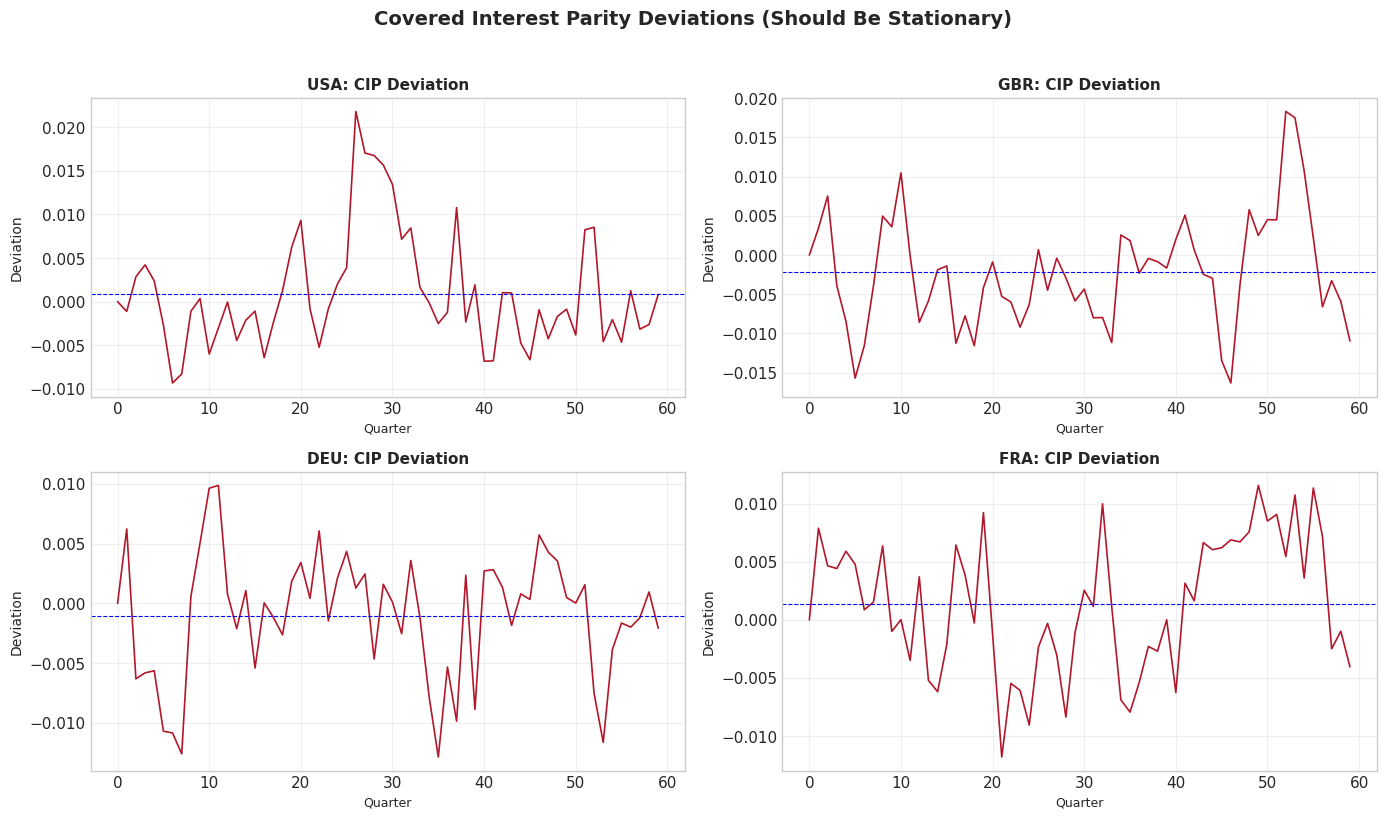

CIP deviations appear mean-reverting, consistent with cointegration.


In [31]:
# Visualize CIP equilibrium error for sample countries
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sample_countries_cip = df_cip['country'].unique()[:4]

for ax, country in zip(axes.flat, sample_countries_cip):
    cdata = df_cip[df_cip['country'] == country]
    # CIP deviation: forward_rate - spot_rate - (i_domestic - i_foreign)/400
    cip_deviation = (
        cdata['forward_rate'].values
        - cdata['spot_rate'].values
        - (cdata['interest_domestic'].values - cdata['interest_foreign'].values) / 400.0
    )
    ax.plot(range(len(cip_deviation)), cip_deviation, linewidth=1.2, color='#b2182b')
    ax.axhline(y=np.mean(cip_deviation), color='blue', linestyle='--', linewidth=0.8)
    ax.set_title(f'{country}: CIP Deviation', fontsize=11, fontweight='bold')
    ax.set_xlabel('Quarter', fontsize=9)
    ax.set_ylabel('Deviation', fontsize=10)
    ax.grid(True, alpha=0.3)

fig.suptitle('Covered Interest Parity Deviations (Should Be Stationary)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../outputs/figures/vecm/05_cip_deviations.png',
            dpi=150, bbox_inches='tight')
plt.show()

print('CIP deviations appear mean-reverting, consistent with cointegration.')

---

## Summary

### Key Takeaways

1. **Non-stationary data** requires careful treatment. VAR in levels yields spurious results; VAR in differences loses long-run information. The **VECM** resolves this dilemma.

2. **Cointegration** means that I(1) variables share common stochastic trends and have a stationary linear combination. The cointegrating vector $\beta$ defines the long-run equilibrium.

3. The **VECM specification** $\Delta y_t = \alpha \beta' y_{t-1} + \sum \Gamma_l \Delta y_{t-l} + \varepsilon_t$ cleanly separates long-run equilibrium ($\alpha \beta'$) from short-run dynamics ($\Gamma$).

4. **Rank selection** via trace and max-eigenvalue tests determines the number of cointegrating relations. This is a critical step before VECM estimation.

5. The **loading matrix** $\alpha$ measures adjustment speeds: how quickly each variable corrects deviations from long-run equilibrium. Half-life calculations give economic interpretation.

6. **Economic restrictions** on $\beta$ (e.g., PPP symmetry) can be tested formally using LR tests, connecting statistical estimation to economic theory.

7. **VECM IRFs** respect cointegration constraints: individual variables may shift permanently, but the cointegrating combination always returns to equilibrium.

8. The VECM framework applies broadly to **any set of cointegrated variables**: PPP, interest rate parity, money demand, term structure, etc.

### Next Steps

| Notebook | Topic |
|---|---|
| **06** | Dynamic Multipliers and Structural Identification |
| **07** | Complete Case Study with Multiple Models |

---

## Exercises

### Exercise 1: Rank Sensitivity to Lag Order (Easy)

Repeat the cointegration rank test for the PPP data using lag orders p = 1, 2, 3, and 4. Does the selected rank change with the lag order? Create a table summarizing the results.

**Hint:** Create a new `PanelVARData` object for each lag order and run `CointegrationRankTest`. Compare `results.selected_rank` across specifications.

In [32]:
# YOUR CODE HERE

### Exercise 2: Higher-Rank VECM Estimation (Medium)

Estimate a VECM with rank = 2 for the PPP data (even if the rank test suggests r = 1). Compare the cointegrating vectors, adjustment speeds, and residual covariance matrix to the rank-1 specification. What does the second cointegrating relation look like? Is it economically interpretable?

**Hint:** Use `PanelVECM(var_data_ppp, rank=2)` and compare results with the rank-1 model estimated above.

In [33]:
# YOUR CODE HERE

### Exercise 3: VECM Residual Stationarity Check (Medium)

Extract the residuals from the estimated VECM and check that they are stationary. Compute the autocorrelation function (ACF) of the residuals for each equation and plot them. Well-specified VECM residuals should resemble white noise.

**Hint:** Access residuals via `vecm_results.residuals`. Use `np.correlate` or `pd.Series.autocorr()` to compute autocorrelations at different lags.

In [34]:
# YOUR CODE HERE

### Exercise 4: VAR vs VECM Forecast Comparison (Hard)

Compare out-of-sample forecast performance of three approaches:
1. VAR in levels (using `PanelVAR`)
2. VAR in first differences (difference the data first, then use `PanelVAR`)
3. VECM (using `PanelVECM`)

For each approach:
- Estimate on the first 50 quarters
- Forecast the last 10 quarters
- Compute RMSE for each variable

Which approach produces the best forecasts? Does the VECM advantage increase at longer horizons?

**Hint:** Split the data by filtering quarters. For the differenced VAR, remember to cumulate the forecasted differences back to levels for a fair comparison.

In [35]:
# YOUR CODE HERE

---

## References

- Engle, R. F., & Granger, C. W. J. (1987). "Co-Integration and Error Correction: Representation, Estimation, and Testing." *Econometrica*, 55(2), 251--276.
- Johansen, S. (1988). "Statistical Analysis of Cointegration Vectors." *Journal of Economic Dynamics and Control*, 12(2-3), 231--254.
- Johansen, S. (1991). "Estimation and Hypothesis Testing of Cointegration Vectors in Gaussian Vector Autoregressive Models." *Econometrica*, 59(6), 1551--1580.
- Larsson, R., Lyhagen, J., & Lothgren, M. (2001). "Likelihood-Based Cointegration Tests in Heterogeneous Panels." *The Econometrics Journal*, 4(1), 109--142.
- Breitung, J., & Pesaran, M. H. (2008). "Unit Roots and Cointegration in Panels." In *The Econometrics of Panel Data* (pp. 279--322). Springer.
- Lutkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer. Chapters 6 and 9.